In [2]:
import pandas as pd

#### Let's make use of a decision tree to determine whether to buy an European Call Option. There's going to be a lot of compounding variables in this.

##### The Binomial Option Pricing Model is a way to price the value of a call/put option. An option is a tradeable asset that allows the owner to shares/commodities at a future date with a pre-determined price (locking in a price). Variables that go into this include volatility of the underlying asset (stock), the amount it will rise or fall, time, the risk free rate, etc.

In [3]:
# Start with mapping the price of Brent. It'll be easier to project share price if we have something to base it off of.
BrentDaily = pd.read_csv('BrentDaily.csv')
display (BrentDaily.head())

,date,value
0,2010-04-22,84.58
1,2010-04-23,86.09
2,2010-04-26,86.72
3,2010-04-27,85.59
4,2010-04-28,84.59


In [4]:
from pandas import Series, DataFrame
import numpy as np
import pandas as pd
from patsy import dmatrices
import warnings
%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [5]:
dailyBrent = pd.read_csv('./BrentDaily.csv')
dailyBrent['BrentClose']= dailyBrent[' value']
ShellShares = pd.read_csv('RDS-A.csv')
ShellShares['ShellClose'] = ShellShares['Adj Close']
Comparisson = dailyBrent.set_index('date').join(ShellShares[['ShellClose','Date']].set_index('Date')).dropna()[['BrentClose','ShellClose']]
display (Comparisson.tail())
print (Comparisson.columns.tolist())

,BrentClose,ShellClose
date,,
2020-04-06,22.58,37.330002
2020-04-07,22.10,37.259998
2020-04-08,25.22,38.070000
2020-04-09,20.23,37.910000
2020-04-13,20.23,37.369999


['BrentClose', 'ShellClose']


Correlation:  0.8939762161190508


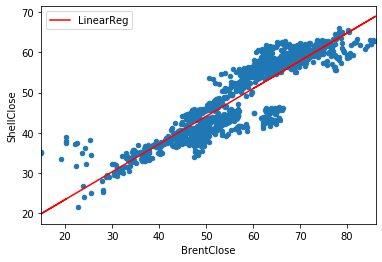

In [26]:
Comparisson = Comparisson.dropna()
Regression = np.polyfit(Comparisson['BrentClose'],Comparisson['ShellClose'], 1)
grid = plt.subplot(1,1,1)
Comparisson['LinearReg'] = np.polyval(Regression,Comparisson['BrentClose'])
Comparisson.plot(x='BrentClose',y='ShellClose', kind='scatter', ax=grid)
Comparisson.plot(x='BrentClose',y='LinearReg', kind='line', ax=grid, color = 'red')
print ("Correlation: ", Comparisson['BrentClose'].corr(Comparisson['ShellClose']))

In [7]:
# This makes a lot of sense, since market prices are largely driven by investor fears/expectations. But there's a ton
# of variation in the data when Brent is <$40. Since that's the current environment, let's look at that more closely

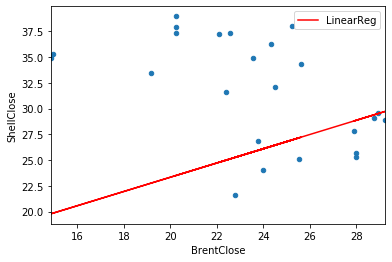

date
2020-03-18   -3.647403
2020-03-16   -3.536560
2020-03-17   -3.189644
2020-03-20   -2.096088
2020-03-19   -2.050350
Name: Difference, dtype: float64

In [28]:
Sub40 = Comparisson[Comparisson['BrentClose']<30]
Sub40['Difference'] = Sub40['ShellClose']-Sub40['LinearReg']
grid = plt.subplot(1,1,1)
Sub40.plot(x='BrentClose',y='ShellClose', kind='scatter', ax=grid)
Sub40.plot(x='BrentClose',y='LinearReg', kind='line', ax=grid, color = 'red')
plt.show()
display (Sub40['Difference'].sort_values(ascending=True).head())

##### There's a ton of volatility in the market right now. In fact, looking at the dataset, the only values that +/- 1 dollar the expectation occured in the last 3 months. Since that's the case, let's filter down to just 2020. However, the model breaks down significantly. In fact, the correlation becomes negative, which doesn't make a whole lot of sense rationally speaking. This gets into behavioral finance, which studies why investors react in certain market conditions/make a given decision. 
#### Furthermore, if we assume a normal distribution of daily rate changes around the mean, the current 2020 data that ends up skewing the model hasn't played out in its fullest yet.
### Regardless, this is a pretty bad model for our projections, especially because the market is in the outlier space at the moment
### So instead, let's look at Shell's stock price as it relates to past financial crises oil price drops specifically.


Correlation at Sub 30 prices:  -0.4279679707527506


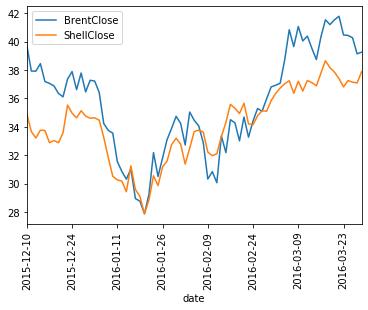

In [131]:
print ('Correlation at Sub 30 prices: ', Sub40['BrentClose'].corr(Sub40['ShellClose']) )
Comparisson2016[['BrentClose','ShellClose']].plot(rot = 90)


Correlation during 2016:  0.8867631627525695
Linear Regression Equation =  0.6324735656477463 * Brent Close +  11.536097831894644


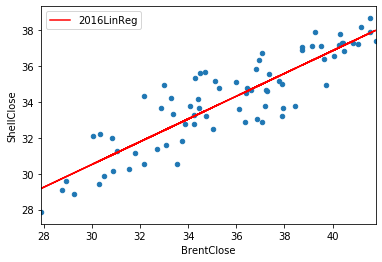

In [140]:
Comparisson2016 = Comparisson.loc['2015-12-1':'2016-03-30']
Regression2016 = np.polyfit(Comparisson2016['BrentClose'],Comparisson2016['ShellClose'], 1)
Comparisson2016['2016LinReg'] = np.polyval(Regression2016,Comparisson2016['BrentClose'])
ax = plt.subplot(1,1,1)
print ('Correlation during 2016: ', Comparisson2016['BrentClose'].corr(Comparisson2016['ShellClose']))
Comparisson2016.plot(x='BrentClose',y='2016LinReg', ax=ax, color='red')
Comparisson2016.plot(x='BrentClose',y='ShellClose',ax=ax,kind='scatter')
print ('Linear Regression Equation = ',str(Regression2016[0]),'* Brent Close + ', str(Regression2016[1]))

#### This looks a lot better, so let's use this as the basis of our Shell share price projection.
#### Now let's use Python to do a Binomial Option Pricing Model, to calculate the value of a European Call on RDS.A
#### We'll factor it in closely with predicted oil prices rather than just outright speculating increases/decreases in share price

##### This model is predicated on the idea that a stock will either increase or decrease by X in Time T. The goal is to generate a risk-neutral replicating portfolio so that changes in the stock price don't affect the ultimate payoff
##### For our example, let's assume that the price per Barrel (at the moment of writing) is 22.41. From the previous Notebook (see FinancialStatements.ipynb), we know that price/barrel has dropped below 50 on average for a quarter twice, once in 2016 and once during the Great Recession. Let's use the volatility during those times as a metric for volatility going forward.


Standard Deviation during Recession:  39.06618192247612
Standard Deviation during 2016:  8.333462665663056


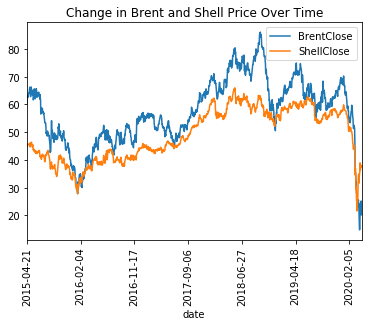

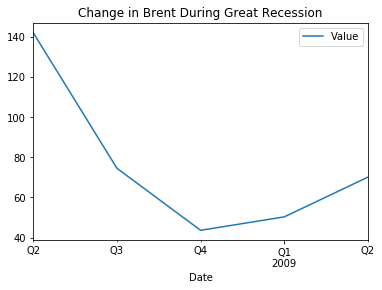

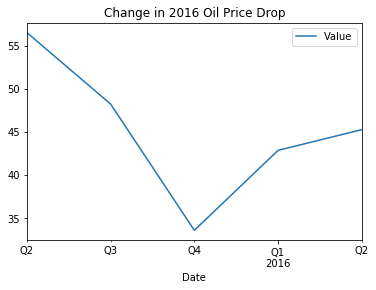

In [135]:
BrentPrices=pd.read_excel('./InterestRates.xlsx', sheet_name='BrentOilPrices', index_col=0)
Comparisson[['BrentClose','ShellClose']].plot(title='Change in Brent and Shell Price Over Time', rot=90)
BrentPrices.loc['2009-06-30':'2008-06-30'].plot(title = 'Change in Brent During Great Recession')
print ('Standard Deviation during Recession: ', BrentPrices.loc['2009-06-30':'2008-06-30'].std()['Value'])
print ('')
print ('Standard Deviation during 2016: ', BrentPrices.loc['2016-06-30': '2015-6-30'].std()['Value'])
BrentPrices.loc['2016-06-30': '2015-6-30'].plot(title = 'Change in 2016 Oil Price Drop')

##### Which volatility do we use for our option pricing model? Or do we use a weighted average of both? Each has advantages and disadvantages. 2009 was the result of a drastic reduction in demand like we see now, while 2016 can be more easily traced back to supply changes (such as the increased oil production coming from the US). However, 2016 is more comprable to the status quo since the amount of variation we're likely to see this time doesn't come close (2009 saw oil prices drop from almost 140 per barrel to the low 30s.)

#### This is where you would probably insert your own model for projecting volatility based on historical trends or some future market outlook For the purposes of this exercise, I'm going to take the 2016 volatility because 1) The pattern more closely resembles what the current market looked like, 2) There are current supply restrictions. Despite May Oil Futures going negative, there will be a slow recovery in terms of demand for oil consumption 3) It's the basis of my previous regression to determine Shell's stock price relationship. So my change in Brent will be by a factor of 8.333.


In [144]:
# Going off that assumption, we can plug the 'risk', or standard deviation, back into the original problem. With Binomial
# option pricing, we assume that the price of Brent can go up or down by 8.333 in one year. However, we have the expected
# future price already in the form of Brent Crude Oil Futures. So we'll use that as the baseline (35.18)
BrentFutureUp = 35.18+8.333
BrentFutureDown = 35.18-8.333
print('Brent Future Up State: ', str(BrentFutureUp), '\nBrent Future Down State: ', str(BrentFutureDown))

Brent Future Up State:  43.513 
Brent Future Down State:  26.847


In [161]:
# Now to project the future states of Shell's price based on these 
ShellFutureUp = BrentFutureUp*Regression2016[0]+Regression2016[1]
ShellFutureDown = BrentFutureDown*Regression2016[0]+Regression2016[1]
ShellCurrentPrice = 35.15
print ('Shell Future Up State: ',str(ShellFutureUp),'\nShell Future Down State: ',str(ShellFutureDown),'\nShell Current Price: ',ShellCurrentPrice)
print ('Assume Strike Price: 35')
AssumedStrike = 35

Shell Future Up State:  39.05692009392503 
Shell Future Down State:  28.516115648839687 
Shell Current Price:  35.15
Assume Strike Price: 35


<img src = 'https://www.investopedia.com/thmb/YV47c9-ibCjREKCi8BoomKWy8fM=/478x0/filters:no_upscale():max_bytes(150000):strip_icc()/binomial-1-5bfd905dc9e77c0051851129' />

##### Strategy will be to create a replicating portfolio by purchasing s number of shares while shorting a call (covered), which will replicate the payoff of a naked call

##### The Pup and Pdown range from (Cost of the Option, - infinity)

In [163]:
u = ShellFutureUp/ShellCurrentPrice
d = ShellFutureDown/ShellCurrentPrice
Pup = max(0,ShellFutureUp-AssumedStrike)
Pdown = max(0, ShellFutureDown-AssumedStrike)
print ('u: ',str(u),'\nd: ',str(d))

u:  1.111149931548365 
d:  0.8112692929968617


##### s refers to the number of shares in the replicating portfolio 
##### PortfolioUpState= s * u * ShellCurrentPrice * Pup
##### PortfolioDownState = s * d * ShellCurrentPrice * Pdown
##### if we set them equal to each other (ie a risk free portfolio), we get the equation: s = [Pup-Pdown]/[x*(u-d)]
##### Binomial Options Pricing Theory rearranges these equations to find a probability q and (1-q) of each of these states
##### Read more 'https://www.investopedia.com/articles/investing/021215/examples-understand-binomial-option-pricing-model.asp'
##### q = e(−rt)−d/(u-d)
##### c=e(−rt)×(q×Pup​+(1−q)×Pdown​)

In [166]:
q = (np.exp(-.0025*1)-d)/(u-d)
print (q)

0.5961723358195449


In [170]:
c = np.exp(-.0025*1)*(q*Pup+(1-q)*Pdown)
print (c)

2.4125845217109236


##### 2.41 is effecitvely the price of an option today that has an exercise price of 35 and a payoff timeline of 1 year, given my assumptions about the oil market. The actual value of a similar option as of 4/22 is closer to 5. Why is this calculation so different from market? This analysis is based solely on a similar recovery from Brent's downturn in 2016, while current market analysis likely includes other factors. Furthermore, there's also a lot of volatility (expected) in the oil commodity market, especially after May 2020 futures went negative. That likely is driving up the value of these options in the current commodities market.

### However, this is just one time period (year) into the future. What happens when we expand the binomial tree?
<img src='https://www.investopedia.com/thmb/L8QSnpMww-zxiFiItNu7JAokkEM=/478x0/filters:no_upscale():max_bytes(150000):strip_icc()/binomial-2-5bfd904e4cedfd002601e625' />

#### This is where recursion comes in to play. Each node in the tree is calculated by interpretting the values of the options at the next node (basically need to work backwards to arrive at time T0). We're implementing the same logic, but it'd be tedious to manually calculate or even code out each step. This issue compounds if the tree grows the 7 or 8 layers. Recurssion allows our python functions to essentially call themselves to iterate through the necessary steps without repetitive code.

In [186]:
LengthOfTree = 2

# This is where the recurssion happens.
def ValueofOption(node,numGrowth):
    # Find out the value of the stock price at the given node with numGrowth periods of growth (u) with probability p
    stockPrice = ShellCurrentPrice*u**numGrowth*d**(node-numGrowth)
    # Assuming we're just dealing with calls, where we'll never make less than 0, and have limitless upside
    ExerciseReturn = max(0, stockPrice - AssumedStrike)
    # If we're at the end of the tree just return the value of the option to the previous leaf
    if node == LengthOfTree:
        return ExerciseReturn
    # Sets up the time value of money factor
    timeValue = np.exp(-.0025*1)
    # Calculates the expectation of the option's payoff by calculating the next 2 leaves' values
    expectedPayoff = ValueofOption(node+1, numGrowth+1)*q+ValueofOption(node+1,numGrowth)*(q-1)
    # Reduces the payoff to the present value
    optionValue = timeValue*expectedPayoff
    
    # Since we're dealing with European calls, there is no option to exercise early. We can easily add this logic in by just returning
    # the max between the optionValue and the Exercise's return
    return (optionValue)
print ('Value of a two year option today given a constant rate of increase in the value of Brent, a strike price of $35: ','${:,.2f}'.format(ValueofOption(0,0)))

Value of a two year option today given a constant rate of increase in the value of Brent, a strike price of $35:  $2.97
